In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import numpy as np
import cv2 as cv
import os

from matplotlib import pyplot as plt

!pip -q install kaggle

os.environ['KAGGLE_USERNAME'] = "yusufsyam"
os.environ['KAGGLE_KEY'] = "ef18b68f1885d208341d4aaee38056d9"

import kaggle

### Load Data

In [2]:
!kaggle datasets download -d tongpython/cat-and-dog

 96% 209M/218M [00:03<00:00, 131MB/s]
100% 218M/218M [00:03<00:00, 68.6MB/s]


In [3]:
!unzip -q /content/cat-and-dog.zip

### Preprocess Data

In [4]:
BATCH_SIZE= 32
IMAGE_SIZE= (224, 224)
IMAGE_DIM= IMAGE_SIZE+(3,)
CLASS_LABELS= ['Cat', 'Dog']

AUTOTUNE= tf.data.experimental.AUTOTUNE

In [5]:
ds= keras.utils.image_dataset_from_directory(
    '/content/training_set/training_set',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True
)

def normalize(img, label):
    return img/255, label

ds= ds.map(normalize).cache('/').prefetch(AUTOTUNE)

Found 8005 files belonging to 2 classes.


In [6]:
ds_test= keras.utils.image_dataset_from_directory(
    '/content/test_set/test_set',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True
)

ds_test= ds_test.map(normalize).cache('/').prefetch(AUTOTUNE)

Found 2023 files belonging to 2 classes.


In [7]:
def view_image(ds, class_labels=None, img_num=8, ncols=4, nrows=2, figsize=None):
    data = next(iter(ds))
    image = data[0].numpy()
    label = data[1].numpy()

    if figsize is None:
        figsize= (ncols*5, nrows*5)
    
    fig = plt.figure(figsize=figsize)

    for i in range(img_num):
        ax = fig.add_subplot(nrows, ncols, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])

        try:
            ax.set_title(f"{class_labels[label[i]]}")
        except:
            pass

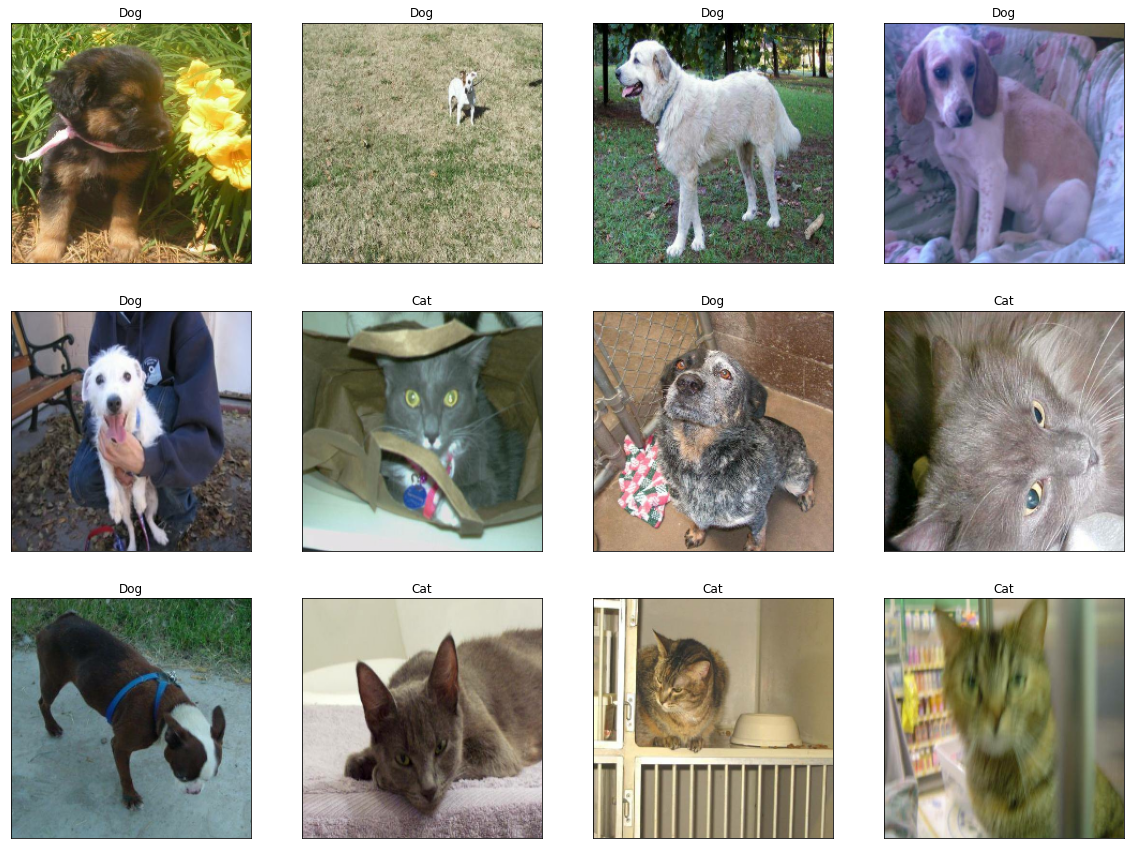

In [8]:
view_image(ds, CLASS_LABELS, 12, nrows=3)

### Building Model

Transfer learning from efficient net v2 (sm)

In [59]:
url= 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

base_model= hub.KerasLayer(url, input_shape=IMAGE_DIM, trainable=False)

In [60]:
data_augmentation = keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.25),
])

In [61]:
model= keras.Sequential([
    data_augmentation,
    base_model,
    keras.layers.Dense(2, 'softmax')
])

In [62]:
optimizer= keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer= optimizer,
    loss= 'sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [64]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor= 0.75, patience=1, min_lr=0.000001, min_delta=0.01)

history= model.fit(ds, epochs=6, validation_data=ds_test, callbacks=[reduce_lr])

Epoch 1/6
251/251 [==============================] - 19s 76ms/step - loss: 0.2208 - accuracy: 0.9072 - val_loss: 0.0666 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 2/6
251/251 [==============================] - 18s 72ms/step - loss: 0.1447 - accuracy: 0.9392 - val_loss: 0.0538 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 3/6
251/251 [==============================] - 18s 72ms/step - loss: 0.1284 - accuracy: 0.9470 - val_loss: 0.0557 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 4/6
251/251 [==============================] - 18s 73ms/step - loss: 0.1202 - accuracy: 0.9529 - val_loss: 0.0526 - val_accuracy: 0.9814 - lr: 7.5000e-04
Epoch 5/6
251/251 [==============================] - 18s 73ms/step - loss: 0.1223 - accuracy: 0.9494 - val_loss: 0.0480 - val_accuracy: 0.9839 - lr: 7.5000e-04
Epoch 6/6
251/251 [==============================] - 18s 72ms/step - loss: 0.1165 - accuracy: 0.9532 - val_loss: 0.0464 - val_accuracy: 0.9834 - lr: 5.6250e-04


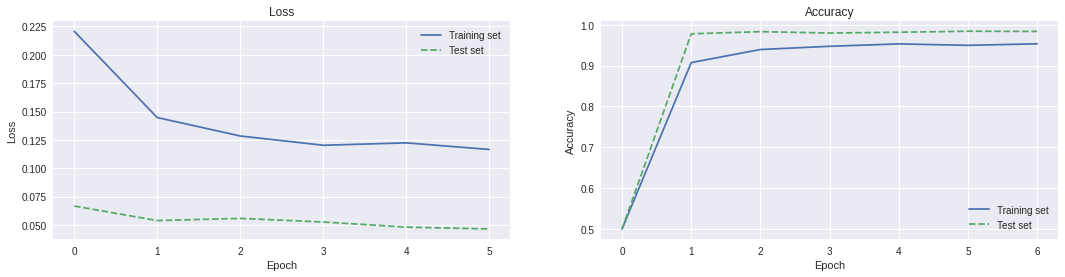

In [65]:
plt.style.use('seaborn')

loss= history.history['loss']
val_loss= history.history['val_loss']

accuracy= [0.5]+history.history['accuracy']
val_accuracy= [0.5]+history.history['val_accuracy']

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()

### Fine Tuning (cancelled)

In [50]:
# base_model.trainable= True

# optimizer= keras.optimizers.Adam(learning_rate=0.00001)

# model.compile(
#     optimizer= optimizer,
#     loss= 'sparse_categorical_crossentropy',
#     metrics= ['accuracy']
# )

In [54]:
# ft_history= model.fit(ds, epochs=2, validation_data=ds_test, callbacks=[reduce_lr])

Epoch 1/2
251/251 [==============================] - 49s 194ms/step - loss: 0.1124 - accuracy: 0.9537 - val_loss: 0.0442 - val_accuracy: 0.9849 - lr: 1.0000e-05
Epoch 2/2
251/251 [==============================] - 49s 194ms/step - loss: 0.0972 - accuracy: 0.9630 - val_loss: 0.0372 - val_accuracy: 0.9868 - lr: 1.0000e-05


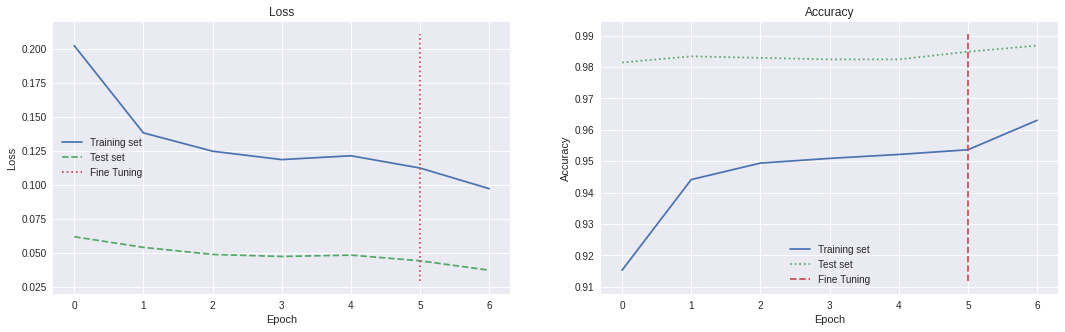

In [55]:
# loss = history.history['loss'] + ft_history.history['loss']
# val_loss = history.history['val_loss'] + ft_history.history['val_loss']

# accuracy = history.history['accuracy'] + ft_history.history['accuracy']
# val_accuracy = history.history['val_accuracy'] + ft_history.history['val_accuracy']

# plt.figure(figsize=(18, 5))

# plt.subplot(1, 2, 1)
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.plot(loss, label='Training set')
# plt.plot(val_loss, label='Test set', linestyle='--')
# plt.plot([5, 5], plt.ylim(),label='Fine Tuning',linestyle='dotted')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.plot(accuracy, label='Training set')
# plt.plot(val_accuracy, label='Test set', linestyle='dotted')
# plt.plot([5, 5], plt.ylim(), label='Fine Tuning', linestyle='--')
# plt.legend()

# plt.show()

### Evaluating on New Data

In [24]:
!kaggle datasets download -d rahul897/catsdogs

 98% 213M/217M [00:03<00:00, 64.3MB/s]
100% 217M/217M [00:03<00:00, 67.8MB/s]


In [29]:
!unzip -q /content/catsdogs.zip -d /content/new_test

In [30]:
ds_test2= keras.utils.image_dataset_from_directory(
    '/content/new_test/training_set/training_set',
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle= True
)

ds_test2= ds_test2.map(normalize).cache('/').prefetch(AUTOTUNE)

Found 8000 files belonging to 2 classes.


In [66]:
model.evaluate(ds_test2)

250/250 [==============================] - 14s 57ms/step - loss: 0.0409 - accuracy: 0.9861


[0.040862180292606354, 0.9861249923706055]